In [1]:
from utz import *
import json
from utz import plots
import plotly.graph_objects as go
import plotly.express as px
from nj_crashes.paths import PLOTS_DIR, RUNDATE_PATH, DB_URI
from nj_crashes.utils import normalized_ytd_days

[Papermill](https://papermill.readthedocs.io/) parameters:

In [2]:
return_img = None

In [3]:
save = partial(plots.save, bg='white', return_img=return_img)

In [4]:
totals = read_sql_table("totals", DB_URI).set_index('year')
crashes = read_sql_table("crashes", DB_URI)

totals

,accidents,injuries,fatalities
year,,,
2008,555,414,590
2009,550,352,584
2010,530,366,556
2011,586,517,627
2012,553,382,589
2013,508,393,542
2014,523,345,556
2015,522,374,562
2016,570,398,602


In [5]:
crashes

,ACCID,CCODE,CNAME,MCODE,MNAME,HIGHWAY,LOCATION,FATALITIES,INJURIES,STREET,FATAL_D,FATAL_P,FATAL_T,FATAL_B,dt
0,1703,01,Atlantic,0102,Atlantic City,446,State/Interstate Authority 446 S MP 1,1.0,1.0,None,NaN,NaN,NaN,NaN,2008-01-01 00:35:00
1,1681,09,Hudson,0910,Union City,None,Bergenline Ave S MP 0 at 6th St,1.0,NaN,Bergenline Ave,NaN,NaN,NaN,NaN,2008-01-01 04:11:00
2,1659,04,Camden,0415,Gloucester Twsp,42,State Highway 42 N MP 8.2,1.0,1.0,None,NaN,NaN,NaN,NaN,2008-01-01 06:46:00
3,1661,20,Union,2004,Elizabeth City,624,County 624 W MP 2.2 at Ikea Dr,1.0,1.0,None,NaN,NaN,NaN,NaN,2008-01-01 12:29:00
4,1811,07,Essex,0716,Nutley Town,648,County 648 E MP .87 at Franklin Ave,1.0,NaN,None,NaN,NaN,NaN,NaN,2008-01-01 18:53:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8994,12929,12,Middlesex,1205,Edison Twsp,1,State Highway 1,1.0,NaN,None,0.0,0.0,1.0,0.0,2024-01-08 02:20:00
8995,12934,15,Ocean,1514,Lakewood Twsp,623,County 623,1.0,NaN,None,0.0,0.0,1.0,0.0,2024-01-08 17:34:00
8996,12937,13,Monmouth,1316,Freehold Twsp,9,State Highway 9,1.0,NaN,None,0.0,0.0,1.0,0.0,2024-01-09 17:35:00
8997,12940,02,Bergen,0219,Fort Lee Boro,None,Bruce Reynolds Blvd,1.0,NaN,Bruce Reynolds Blvd,0.0,0.0,1.0,0.0,2024-01-10 05:09:00


In [6]:
with open(RUNDATE_PATH, 'r') as f:
    rundate = to_dt(json.load(f)['rundate'])

rundate_ytd_days = normalized_ytd_days(rundate)
rundate_str = rundate.strftime('%Y-%m-%d')
cur_month = rundate.strftime('%Y-%m')
cur_month_dt = to_dt(cur_month).tz_localize(rundate.tz)
cur_year = cur_month_dt.year
cur_year_dt = to_dt(f'{cur_year}').tz_localize(rundate.tz)
nxt_year_dt = to_dt(f'{cur_year + 1}').tz_localize(rundate.tz)
print(rundate)
print(cur_month_dt)
print(cur_year_dt)
print(nxt_year_dt)

2024-01-13 10:00:02
2024-01-01 00:00:00
2024-01-01 00:00:00
2025-01-01 00:00:00


## YTD Calculations

In [7]:
all_days = pd.DataFrame([
    dict(Days=days, Text=(to_dt(f'{2022}') + pd.Timedelta(days=days-1)).strftime('%b %-d'))
    for days in range(1, 366)
]).set_index('Days')
all_days

,Text
Days,
1,Jan 1
2,Jan 2
3,Jan 3
4,Jan 4
5,Jan 5
...,...
361,Dec 27
362,Dec 28
363,Dec 29


In [8]:
def fill_all_days(df):
    df = df.set_index('Days').merge(
        all_days,
        left_index=True,
        right_index=True,
        how='right',
    )
    years = df.Year.dropna().unique()
    if len(years) > 1:
        raise ValueError(f"Years: {years}")
    [year] = years
    if year == rundate.year:
        df = df[df.index < rundate_ytd_days]
    df = df.drop(columns='Year')
    df['YTD Deaths'] = df['YTD Deaths'].ffill().fillna(0).astype(int)
    return df    

In [9]:
ytds = crashes[['dt', 'FATALITIES']].copy()
ytds['Year'] = ytds.dt.dt.year
ytds['Days'] = ytds.dt.apply(normalized_ytd_days)
ytds = (
    ytds
    .groupby('Year', group_keys=False)
    .apply(lambda df: (
        df.assign(**{
            'YTD Deaths': df.FATALITIES.cumsum().astype(int)
        })
    ))
)
ytds = (
    ytds[['Year', 'Days', 'YTD Deaths']]
    .groupby(['Year', 'Days'])
    .max()
    .reset_index()
)

ytds = ytds.groupby('Year').apply(fill_all_days).reset_index()
ytds

,Year,Days,YTD Deaths,Text
0,2008,1,5,Jan 1
1,2008,2,6,Jan 2
2,2008,3,8,Jan 3
3,2008,4,10,Jan 4
4,2008,5,12,Jan 5
...,...,...,...,...
5847,2024,8,9,Jan 8
5848,2024,9,10,Jan 9
5849,2024,10,12,Jan 10
5850,2024,11,12,Jan 11


In [10]:
cur_ytds = ytds[ytds.Year == rundate.year]
cur_ytd_deaths = 0 if cur_ytds.empty else cur_ytds.iloc[-1]['YTD Deaths']

prv_ytd = ytds[ytds.Year == rundate.year - 1]
prv_end_deaths = prv_ytd.iloc[-1]['YTD Deaths']
prv_ytd_deaths = prv_ytd[prv_ytd.Days == rundate_ytd_days].iloc[-1]['YTD Deaths']
prv_roy_ratio = prv_end_deaths / prv_ytd_deaths

projected_records_total = int(cur_ytd_deaths * prv_roy_ratio)
prv_ytd_ratio = cur_ytd_deaths / prv_ytd_deaths
pct_change = (prv_ytd_ratio - 1) * 100

print(f'Current YTD Deaths ({rundate_str}): {cur_ytd_deaths}')
print(f'Previous year YTD Deaths ({rundate_str}): {prv_ytd_deaths}')
print(f'Projected {rundate.year} total: {projected_records_total}')
print(f'{pct_change:.1f}% change')

projected_records_total, cur_ytd_deaths, prv_ytd_deaths, prv_roy_ratio

Current YTD Deaths (2024-01-13): 12
Previous year YTD Deaths (2024-01-13): 21
Projected 2024 total: 354
-42.9% change


(354, 12, 21, 29.523809523809526)

In [11]:
rundate_year_frac = (rundate - cur_year_dt) / (nxt_year_dt - cur_year_dt)
year_frac = (cur_month_dt - cur_year_dt) / (nxt_year_dt - cur_year_dt)
rundate_year_frac, year_frac

(0.03392538200769075, 0.0)

### Color utilities

In [12]:
from utz.colors import RGB, color_interp, colors_lengthen, swatches
from nj_crashes.colors import get_colors, gridcolor, px_colors

years = totals.index.unique()
colors = get_colors(len(years))
black, red, year_colors = colors.black, colors.red, colors.year_colors
colors

{'black': '#000004', 'red': '#ba3853', 'year_colors': ['#fcffa4', '#f9e56a', '#f7ca36', '#f9ab17', '#f78e0d', '#ef721f', '#e15b31', '#d04643', '#ba3853', '#a22b60', '#882268', '#6f196c', '#55106b', '#3b0c5d', '#200c46', '#0f0626', '#000004']}

In [13]:
month_starts = [
    to_dt(f'{cur_year}-{m}').strftime('%b 1')
    for m in range(1, 13)
]
month_starts

['Jan 1',
 'Feb 1',
 'Mar 1',
 'Apr 1',
 'May 1',
 'Jun 1',
 'Jul 1',
 'Aug 1',
 'Sep 1',
 'Oct 1',
 'Nov 1',
 'Dec 1']

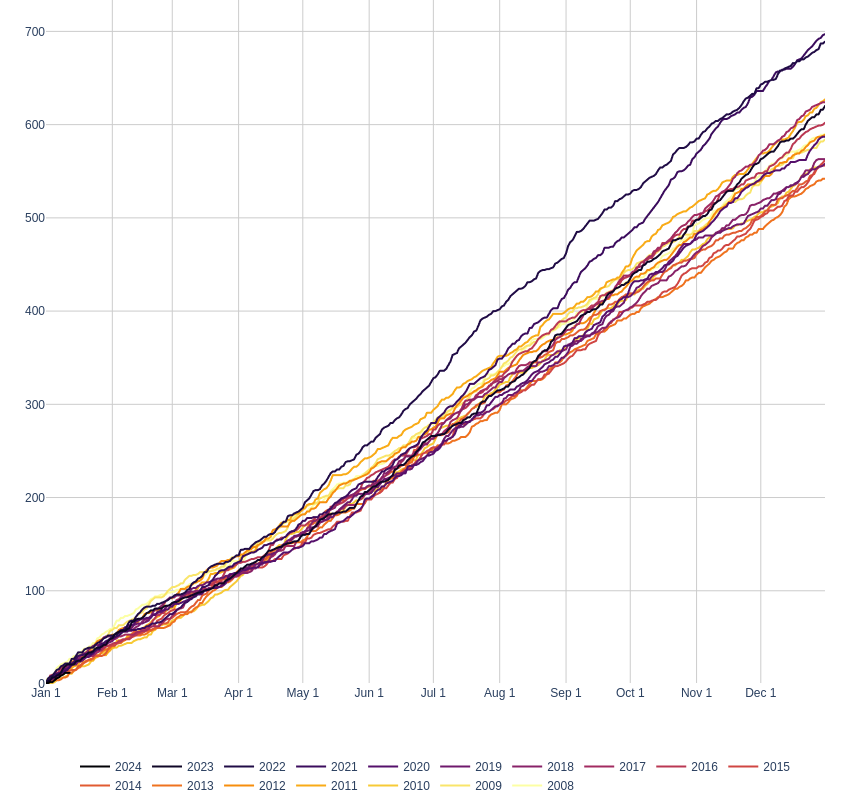

In [14]:
save(
    px.line(
        ytds,
        x='Text', y='YTD Deaths', color='Year',
        color_discrete_sequence=year_colors,
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=month_starts,
        ticktext=month_starts,
    ),
    legend=dict(traceorder='reversed',),
    #bottom_legend=False,
    title='YTD Traffic Deaths',
    name='ytd-deaths',
    hoverx='x',
    bg='white',
    ygrid='#ccc',
    xgrid='#ccc',
    w=850,
    h=800,
)

### Group by year

In [15]:
dt = crashes.dt.dt
fatalities_per_year = crashes.FATALITIES.groupby(dt.year).sum().astype(int).rename('NJSP records')

#### NJSP reports a "total deaths" that is typically ≈5% higher than the crash records' total

In [16]:
totals

,accidents,injuries,fatalities
year,,,
2008,555,414,590
2009,550,352,584
2010,530,366,556
2011,586,517,627
2012,553,382,589
2013,508,393,542
2014,523,345,556
2015,522,374,562
2016,570,398,602


In [17]:
njsp_totals = totals.fatalities.rename('NJSP total')
njsp_diff = (totals.fatalities - fatalities_per_year).rename('NJSP diff')
njsp_totals = sxs(
    fatalities_per_year,
    njsp_totals,
    njsp_diff,
    round(njsp_diff / njsp_totals * 100, 1).apply(lambda pct: f'{"+" if pct >= 0 else "-"}{pct}%').rename('NJSP diff %'),
)
zero_rows = (njsp_totals['NJSP total'] == 0) & (njsp_totals.isna().any(axis=1))
years_mask = ~zero_rows
drop_years = njsp_totals[zero_rows].index.tolist()
if drop_years:
    err(f"Dropping years: {drop_years}")
    njsp_totals = njsp_totals[years_mask]
njsp_totals

,NJSP records,NJSP total,NJSP diff,NJSP diff %
2008,590,590,0,+0.0%
2009,584,584,0,+0.0%
2010,556,556,0,+0.0%
2011,627,627,0,+0.0%
2012,589,589,0,+0.0%
2013,542,542,0,+0.0%
2014,556,556,0,+0.0%
2015,562,562,0,+0.0%
2016,602,602,0,+0.0%
2017,624,624,0,+0.0%


### Group by month

In [18]:
ym = crashes.dt.apply(lambda d: d.strftime('%Y-%m')).rename('ym')
ym

0       2008-01
1       2008-01
2       2008-01
3       2008-01
4       2008-01
         ...   
8994    2024-01
8995    2024-01
8996    2024-01
8997    2024-01
8998    2024-01
Name: ym, Length: 8999, dtype: object

In [19]:
fatalities_per_month = crashes[crashes.dt < cur_month].FATALITIES.groupby(ym).sum()
fatalities_per_month

ym
2008-01    59.0
2008-02    40.0
2008-03    33.0
2008-04    50.0
2008-05    46.0
           ... 
2023-08    64.0
2023-09    52.0
2023-10    65.0
2023-11    63.0
2023-12    61.0
Name: FATALITIES, Length: 192, dtype: float64

### Rolling avg

In [20]:
rolling = fatalities_per_month.rolling(12).mean()
rolling

ym
2008-01          NaN
2008-02          NaN
2008-03          NaN
2008-04          NaN
2008-05          NaN
             ...    
2023-08    50.916667
2023-09    49.583333
2023-10    50.250000
2023-11    50.750000
2023-12    51.666667
Name: FATALITIES, Length: 192, dtype: float64

In [21]:
mos = (
    sxs(
        dt.year.rename('year'),
        dt.month.rename('month'),
        crashes.FATALITIES,
    )
    .groupby(['year', 'month']).sum()
)
mos

FATALITIES
year month            
2008 1            59.0
     2            40.0
     3            33.0
     4            50.0
     5            46.0
...                ...
2023 9            52.0
     10           65.0
     11           63.0
     12           61.0
2024 1            12.0

[193 rows x 1 columns]

In [22]:
pivoted = mos.reset_index().sort_values(['month', 'year'])
pivoted = pivoted[pivoted.apply(lambda r: to_dt('%d-%02d' % (r.year, r.month)).tz_localize(cur_month_dt.tz) < cur_month_dt, axis=1)]
pivoted

,year,month,FATALITIES
0,2008,1,59.0
12,2009,1,57.0
24,2010,1,37.0
36,2011,1,36.0
48,2012,1,52.0
...,...,...,...
143,2019,12,51.0
155,2020,12,47.0
167,2021,12,61.0
179,2022,12,50.0


In [23]:
by_month = crashes.FATALITIES.groupby([dt.year, dt.month]).sum()
by_month

dt    dt
2008  1     59.0
      2     40.0
      3     33.0
      4     50.0
      5     46.0
            ... 
2023  9     52.0
      10    65.0
      11    63.0
      12    61.0
2024  1     12.0
Name: FATALITIES, Length: 193, dtype: float64

### Break out victim "types"

Check victim "type" subtotals vs. total:

In [24]:
fatal_totals = sxs(*[crashes[f'FATAL_{t}'].fillna(0) for t in 'DTPB']).sum(axis=1)
sxs(crashes.dt, (crashes.FATALITIES - fatal_totals).rename('diff')).groupby(dt.year)['diff'].sum()

dt
2008    590.0
2009    584.0
2010    556.0
2011    627.0
2012    589.0
2013    542.0
2014    556.0
2015    562.0
2016    602.0
2017    624.0
2018    563.0
2019    558.0
2020      0.0
2021      0.0
2022      0.0
2023      0.0
2024      0.0
Name: diff, dtype: float64

Cross-reference with annual totals, populate "unknown" subtotal:

In [25]:
base_type_cols_map = {
    'FATAL_D': 'Drivers',
    'FATAL_T': 'Pedestrians',
    'FATAL_P': 'Passengers',
    'FATAL_B': 'Cyclists',
}
base_type_cols = list(base_type_cols_map.keys())

In [26]:
base_type_cols

['FATAL_D', 'FATAL_T', 'FATAL_P', 'FATAL_B']

In [27]:
from nj_crashes.paths import DATA_DIR

In [28]:
year_stats = read_csv(f'{DATA_DIR}/year_types.csv').astype(int).set_index('year')
year_stats

,crashes,driver,passenger,cyclist,pedestrian,fatalities
year,,,,,,
2008,555,320,112,20,138,590
2009,550,315,98,14,157,584
2010,530,303,99,13,141,556
2011,586,362,105,17,143,627
2012,553,309,103,14,163,589
2013,508,304,92,14,132,542
2014,523,295,80,11,170,556
2015,522,276,96,17,173,562
2016,570,330,89,17,166,602


In [29]:
year_stats_cols = {
    'driver': 'FATAL_D',
    'pedestrian': 'FATAL_T',
    'passenger': 'FATAL_P',
    'cyclist': 'FATAL_B',
}
year_type_sums = (
    sxs(
        crashes.dt,
        crashes[base_type_cols].fillna(0)
    )
    .groupby(dt.year.rename('year'))
    [base_type_cols]
    .sum()
    .astype(int)
)
year_type_sums.loc[range(2008, 2020)] = year_stats.rename(columns=year_stats_cols).loc[range(2008, 2020), year_stats_cols.values()]
year_type_sums

,FATAL_D,FATAL_T,FATAL_P,FATAL_B
year,,,,
2008,320,138,112,20
2009,315,157,98,14
2010,303,141,99,13
2011,362,143,105,17
2012,309,163,103,14
2013,304,132,92,14
2014,295,170,80,11
2015,276,173,96,17
2016,330,166,89,17


In [30]:
year_sums = year_type_sums.sum(axis=1).rename('sum')
year_totals = totals.fatalities.rename('Total')
missing = njsp_totals['NJSP diff'].rename('Missing')
unknown = (year_totals - year_sums - missing).rename('FATAL_U')

type_cols_map = { **base_type_cols_map, 'FATAL_U': 'Unknown' }
type_cols = list(type_cols_map.keys())

year_types = (
    sxs(
        year_type_sums,
        year_sums,
        year_totals,
        unknown,
        missing,
    )
    [ type_cols + [ 'Missing', 'Total', ] ]
    .rename(columns=type_cols_map)
)[years_mask]
value_cols = list(type_cols_map.values())
year_types

,Drivers,Pedestrians,Passengers,Cyclists,Unknown,Missing,Total
2008,320,138,112,20,0,0,590
2009,315,157,98,14,0,0,584
2010,303,141,99,13,0,0,556
2011,362,143,105,17,0,0,627
2012,309,163,103,14,0,0,589
2013,304,132,92,14,0,0,542
2014,295,170,80,11,0,0,556
2015,276,173,96,17,0,0,562
2016,330,166,89,17,0,0,602
2017,339,183,86,16,0,0,624


In [31]:
assert (missing == 0).all()
assert (unknown == 0).all()
year_types = year_types.drop(columns=['Unknown', 'Missing'])

In [32]:
year_types

,Drivers,Pedestrians,Passengers,Cyclists,Total
2008,320,138,112,20,590
2009,315,157,98,14,584
2010,303,141,99,13,556
2011,362,143,105,17,627
2012,309,163,103,14,589
2013,304,132,92,14,542
2014,295,170,80,11,556
2015,276,173,96,17,562
2016,330,166,89,17,602
2017,339,183,86,16,624


In [33]:
total_errors = sxs(year_types.Total, njsp_totals['NJSP total'])[year_types.Total != njsp_totals['NJSP total']]
assert total_errors.empty, total_errors

In [34]:
compute_projected = not drop_years
if compute_projected:
    year_types['Projected'] = 0
    prv_year = cur_year - 1
    cur_total = year_types.loc[cur_year, 'Total']
    prv_total = year_types.loc[prv_year, 'Total']
    projected_total = prv_total * prv_ytd_ratio
    #projected_total = cur_total * prv_roy_ratio
    projected_remaining = int(projected_total - cur_total)
    year_types.loc[cur_year, 'Projected'] = projected_remaining
    year_types['Projected Total'] = year_types.Total + year_types.Projected
else:
    err(f"Skipping projections due to empty years: {drop_years}")

In [35]:
year_types

,Drivers,Pedestrians,Passengers,Cyclists,Total,Projected,Projected Total
2008,320,138,112,20,590,0,590
2009,315,157,98,14,584,0,584
2010,303,141,99,13,556,0,556
2011,362,143,105,17,627,0,627
2012,309,163,103,14,589,0,589
2013,304,132,92,14,542,0,542
2014,295,170,80,11,556,0,556
2015,276,173,96,17,562,0,562
2016,330,166,89,17,602,0,602
2017,339,183,86,16,624,0,624


In [36]:
cur_year

2024

In [37]:
recent_totals = {
    (cur_year - 2): year_types.loc[cur_year - 2, 'Total'],
    (cur_year - 1): year_types.loc[cur_year - 1, 'Total'],
}
if cur_year not in drop_years:
    recent_totals[cur_year] = year_types.loc[cur_year, 'Projected Total']
recent_totals

{2022: 689, 2023: 620, 2024: 354}

In [38]:
projected_dict = year_types.dropna().to_dict('index')
projected_dict

{2008: {'Drivers': 320,
  'Pedestrians': 138,
  'Passengers': 112,
  'Cyclists': 20,
  'Total': 590,
  'Projected': 0,
  'Projected Total': 590},
 2009: {'Drivers': 315,
  'Pedestrians': 157,
  'Passengers': 98,
  'Cyclists': 14,
  'Total': 584,
  'Projected': 0,
  'Projected Total': 584},
 2010: {'Drivers': 303,
  'Pedestrians': 141,
  'Passengers': 99,
  'Cyclists': 13,
  'Total': 556,
  'Projected': 0,
  'Projected Total': 556},
 2011: {'Drivers': 362,
  'Pedestrians': 143,
  'Passengers': 105,
  'Cyclists': 17,
  'Total': 627,
  'Projected': 0,
  'Projected Total': 627},
 2012: {'Drivers': 309,
  'Pedestrians': 163,
  'Passengers': 103,
  'Cyclists': 14,
  'Total': 589,
  'Projected': 0,
  'Projected Total': 589},
 2013: {'Drivers': 304,
  'Pedestrians': 132,
  'Passengers': 92,
  'Cyclists': 14,
  'Total': 542,
  'Projected': 0,
  'Projected Total': 542},
 2014: {'Drivers': 295,
  'Pedestrians': 170,
  'Passengers': 80,
  'Cyclists': 11,
  'Total': 556,
  'Projected': 0,
  'Projec

In [39]:
with open(f'{PLOTS_DIR}/projected_totals.json', 'w') as f:
    json.dump(projected_dict, f, indent=4)

### Fatalities per year (by type)

In [40]:
ytc = colors_lengthen(px_colors, 7)
print(' '.join(ytc))
swatches(ytc)

#000004 #320c56 #781c6d #ba3853 #ed6925 #f9b621 #fcffa4


<span style="font-family: monospace">#000004 <span style="color: #000004">██████</span></span> <span style="font-family: monospace">#320c56 <span style="color: #320c56">██████</span></span> <span style="font-family: monospace">#781c6d <span style="color: #781c6d">██████</span></span> <span style="font-family: monospace">#ba3853 <span style="color: #ba3853">██████</span></span> <span style="font-family: monospace">#ed6925 <span style="color: #ed6925">██████</span></span> <span style="font-family: monospace">#f9b621 <span style="color: #f9b621">██████</span></span> <span style="font-family: monospace">#fcffa4 <span style="color: #fcffa4">██████</span></span>

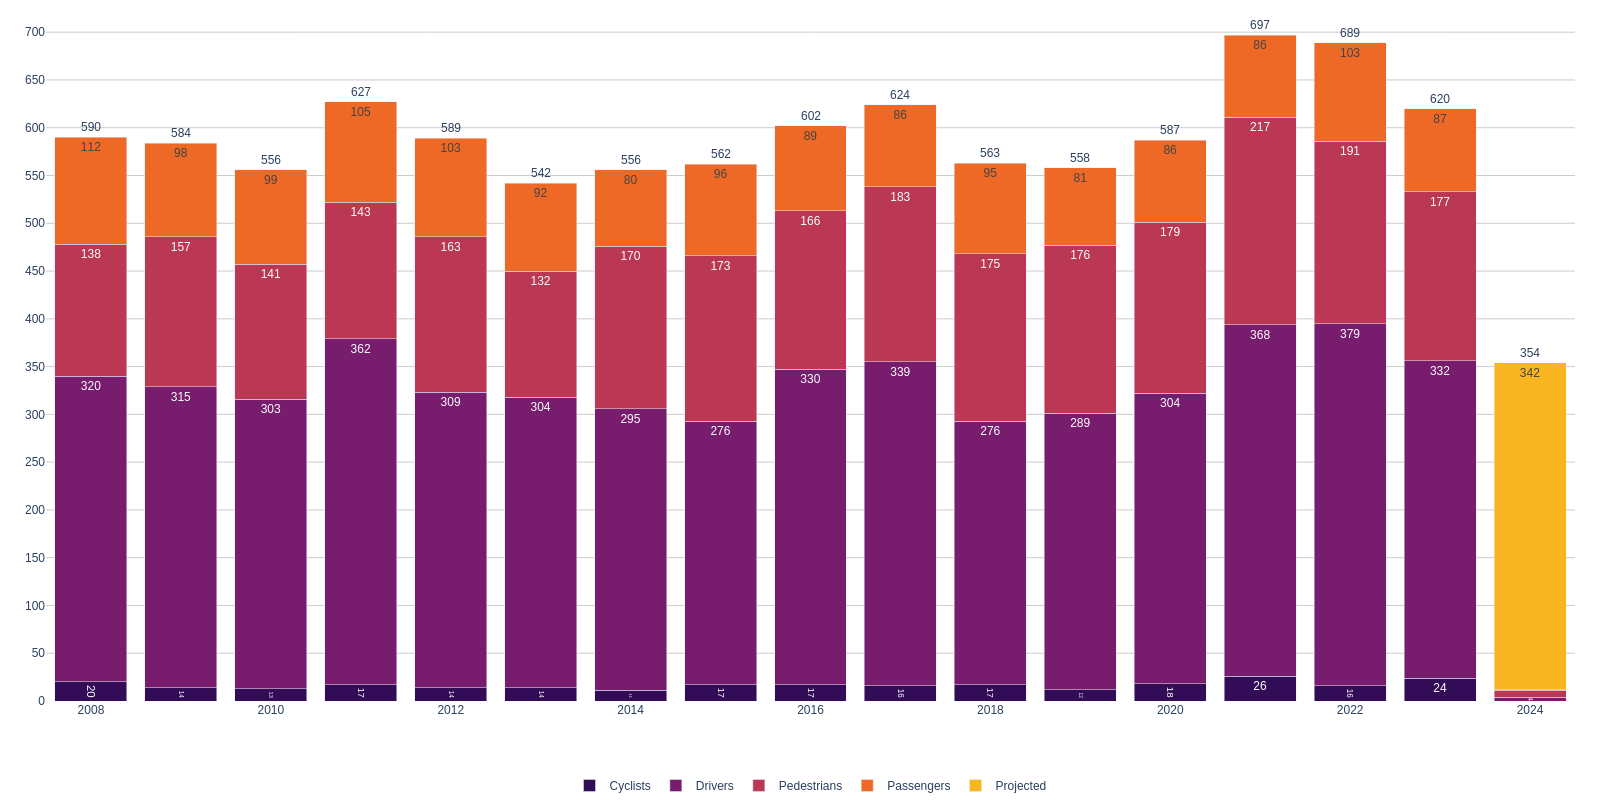

In [41]:
type_labels_map = [
    #'Unknown',
    'Cyclists',
    'Drivers',
    'Pedestrians',
    'Passengers',
    *(['Projected'] if compute_projected else []),
]
fig = (
    px.bar(
        year_types[type_labels_map].replace(0, nan),
        barmode='stack',
        color_discrete_sequence=ytc[1:],
        text_auto='%d',
    )
    .update_yaxes(
        gridcolor=gridcolor,
        dtick=50,
    )
)
for year, projected_total in year_types['Projected Total'].to_dict().items():
    fig.add_annotation(
        x=year, y=projected_total,
        text=projected_total,
        showarrow=False,
        yshift=10,
    )
save(
    fig,
    title=f'NJ Traffic Deaths per Year (by victim type)',
    name='fatalities_per_year_by_type',
    hoverx=True,
    w=1600,
    h=800,
)

### Fatalities per month (by victim type)

In [42]:
crash_type_cols = [ col for col in type_cols if col != 'FATAL_U' ]
month_types = (
    sxs(
        crashes.dt,
        crashes[crash_type_cols].fillna(0)
    )
    [ dt.year >= 2020 ]
    .groupby([
        dt.year.rename('year'),
        dt.month.rename('month'),
    ])
    [crash_type_cols]
    .sum()
    .astype(int)
)

month_types = month_types.reset_index()
month_types['dt'] = (
    month_types
    [['year', 'month']]
    .apply(lambda r: '%04d-%02d' % (r['year'], r['month']), axis=1)
)
month_types = month_types.set_index('dt').drop(columns=['year', 'month'])
month_types

,FATAL_D,FATAL_T,FATAL_P,FATAL_B
dt,,,,
2020-01,21,18,8,2
2020-02,15,17,2,0
2020-03,11,16,8,1
2020-04,17,8,2,1
2020-05,28,13,9,2
2020-06,30,8,9,0
2020-07,30,19,8,5
2020-08,31,8,14,1
2020-09,31,21,5,0


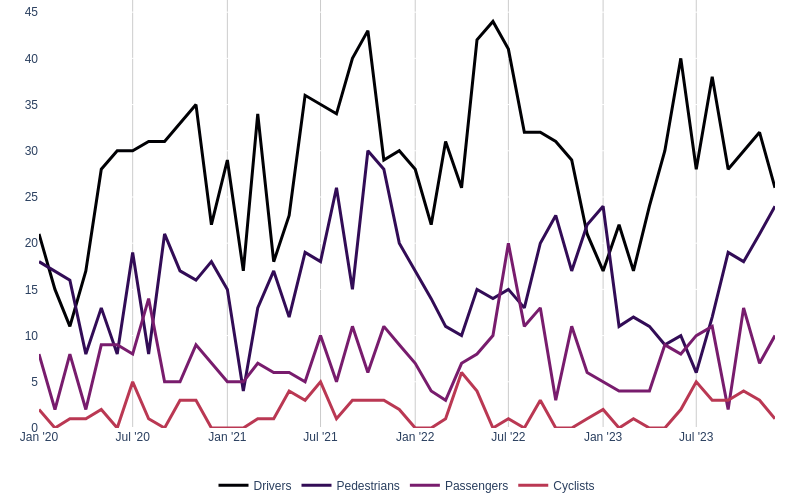

In [43]:
type_colors = colors_lengthen(px_colors, 7)

fig = px.line(
    month_types.rename(columns=type_cols_map).loc[to_dt(month_types.index) < cur_month],
    labels={'variable': '',},
    color_discrete_sequence=type_colors,
)
fig.update_traces(line=dict(width=3))
save(
    fig,
    title='NJ Traffic Deaths per Month (by victim type)',
    name='fatalities_per_month_by_type',
    hoverx=True,
    xgrid=gridcolor,
    xaxis=dict(
        tickformat="%b '%y",
    ),
    w=800,
)

### Fatalities per month

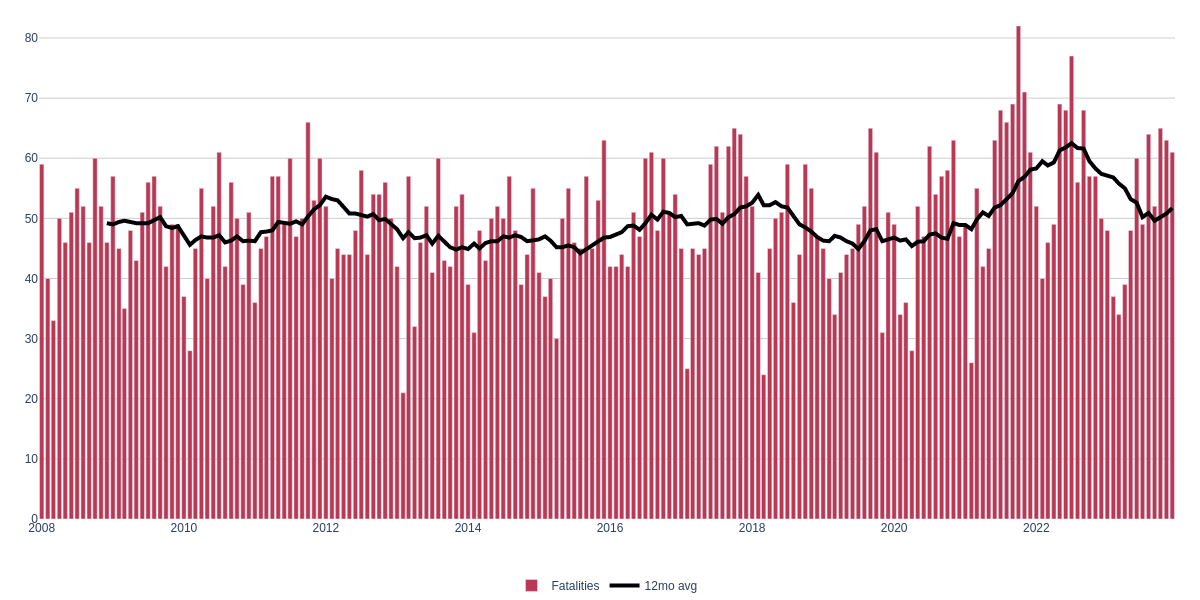

In [44]:
fig = go.Figure()
fig.add_trace(go.Bar(x=fatalities_per_month.index, y=fatalities_per_month.values, name='Fatalities', marker_color=red))
fig.add_trace(go.Scatter(x=rolling.index, y=rolling.apply(partial(round, ndigits=1)), name='12mo avg', line={'width': 4, 'color': black, }))
fig.update_yaxes(gridcolor=gridcolor)
save(
    fig,
    title='NJ Traffic Deaths per Month',
    name='fatalities_per_month',
    hoverx=True,
    w=1200, h=600,
)

In [45]:
month_names = [ to_dt('2022-%02d' % i).strftime('%b') for i in range(1, 13) ]
print(' '.join(month_names))

Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec


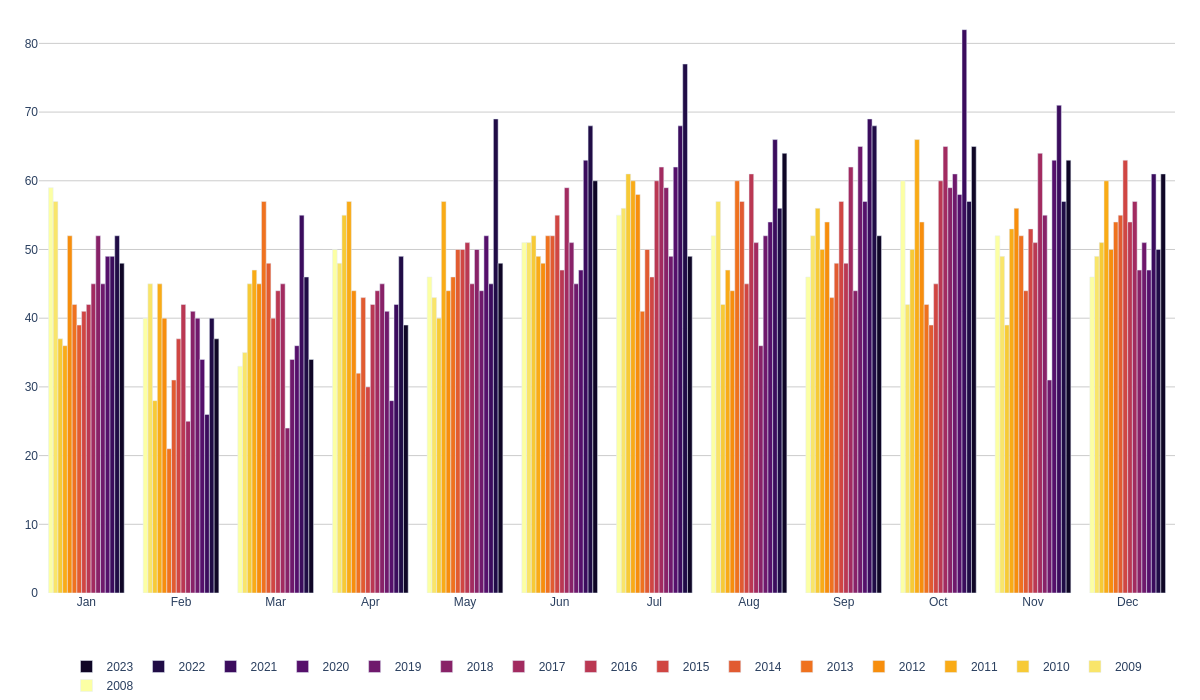

In [46]:
fig = px.bar(
    x = pivoted.month,
    y = pivoted.FATALITIES,
    color = pivoted.year.astype(str),
    color_discrete_sequence=year_colors,
    labels=dict(color='', x='', y='',),
    barmode='group',
).update_yaxes(
    gridcolor=gridcolor,
)
save(
    fig,
    title='NJ Traffic Deaths, by Month',
    name='fatalities_by_month_bars',
    legend=dict(traceorder='reversed'),
    xaxis=dict(
        tickmode = 'array',
        tickvals = list(range(1, 13)),
        ticktext = month_names,
    ),
    hoverx=True,
    w=1200, h=700,
)

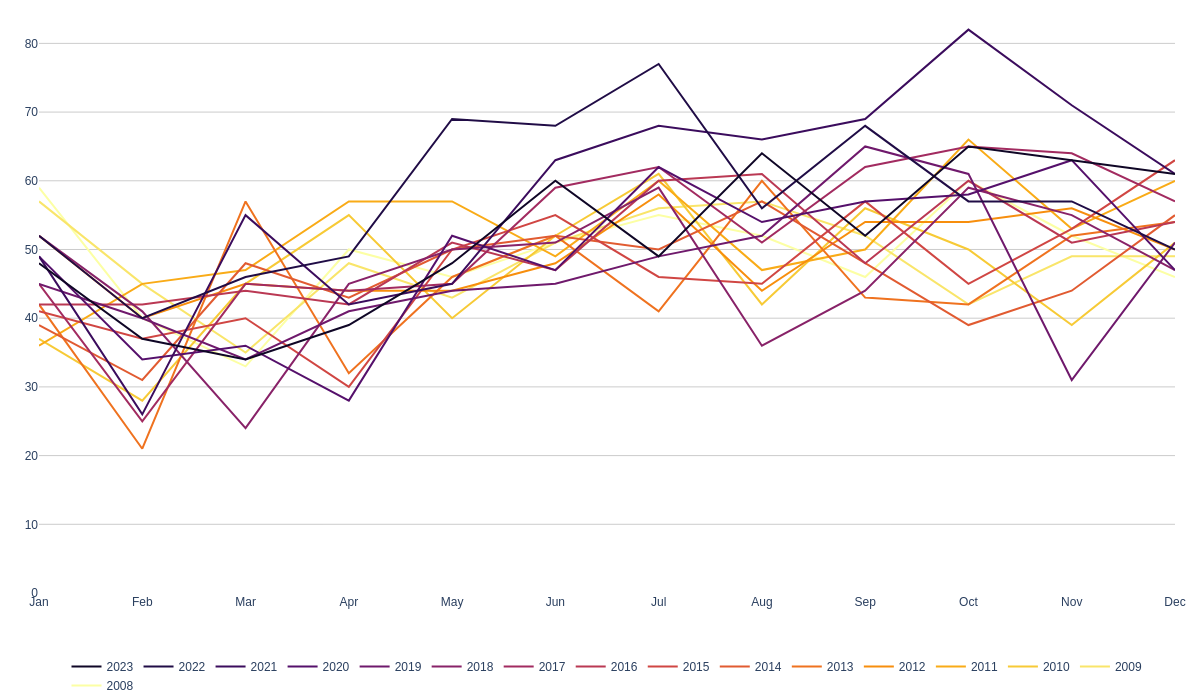

In [47]:
fig = px.line(
    x = pivoted.month,
    y = pivoted.FATALITIES,
    color = pivoted.year,
    color_discrete_sequence=year_colors,
    labels={ 'color': '', 'x': '', 'y': '' },
).update_yaxes(
    gridcolor=gridcolor,
)
save(
    fig,
    title='NJ Traffic Deaths by Month',
    name='fatalities_by_month_lines',
    xaxis=dict(
        tickmode = 'array',
        tickvals = list(range(1, 13)),
        ticktext = month_names,
    ),
    legend=dict(traceorder='reversed'),
    hoverx=True,
    w=1200, h=700,
)